In [2]:
pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-27gyi7ux
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-27gyi7ux
  Resolved https://github.com/huggingface/transformers to commit 0dd65a03198424a41ec6948e445c313e9f292939
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# feature extractor

In [2]:
pip install tokenizers==0.13.2

  Obtaining dependency information for tokenizers==0.13.2 from https://files.pythonhosted.org/packages/9d/63/4559700815b47706bce5b75bf926960d673147b00720b645cddb79499370/tokenizers-0.13.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 4.3 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.42.0.dev0 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.13.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from transformers import AutoFeatureExtractor

model_id = "m-a-p/MERT-v1-330M"

feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

sampling_rate = feature_extractor.sampling_rate

/home/budos/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

# load dataset

In [2]:

from datasets import load_dataset, Audio

dataset = load_dataset("audiofolder", data_dir="audio_data")
dataset = dataset.cast_column('audio', Audio(sampling_rate=sampling_rate))


Resolving data files:   0%|          | 0/96 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset audiofolder downloaded and prepared to /home/budos/.cache/huggingface/datasets/audiofolder/default-07eb83458078d5fd/0.0.0/6cbdd16f8688354c63b4e2a36e1585d05de285023ee6443ffd71c4182055c0fc. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## split dataset

In [3]:

dataset = dataset["train"].train_test_split(seed=42, shuffle=True, test_size=0.1)

# tokenization

In [5]:
max_duration = 7.0

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        # padding='max_length',
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True
    )
    return inputs

In [6]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=["audio"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 86
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 10
    })
})

# load model

In [7]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_id, trust_remote_code=True)

/home/budos/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

configuration_MERT.py:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/m-a-p/MERT-v1-330M:
- configuration_MERT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_MERT.py:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/m-a-p/MERT-v1-330M:
- modeling_MERT.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/home/budos/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/budos/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/budos/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at m-a-p/MERT-v1-330M were not used when initializing MERTModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing MERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MERTModel were not initialized from the model checkpoint at m-a-p/MERT-v1-330M and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model.eval()

MERTModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): MERTFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): HubertEncoderStableLayerNorm(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      

# visualization

In [9]:
t0 = torch.FloatTensor( dataset_encoded['train'][0]['input_values'] )
tt0 = t0.view(1, t0.shape[0])
print('tt0: ', dataset['train'][0]['audio']['path'])
print('tt0.shape: ', tt0.shape)

t1 = torch.FloatTensor( dataset_encoded['train'][1]['input_values'] )
tt1 = t1.view(1, t1.shape[0])
print('tt1: ', dataset['train'][1]['audio']['path'])
print('tt1.shape: ', tt1.shape)

tt0:  /mnt/36f89787-1851-40b9-9c13-f3443db74ea1/nid/uni/efarmosmenhMhxanikiMAth/teliki/test/audio_data/train/Aluminum/circular_plate_3mm_hammer_set4_hit11.wav
tt0.shape:  torch.Size([1, 77434])
tt1:  /mnt/36f89787-1851-40b9-9c13-f3443db74ea1/nid/uni/efarmosmenhMhxanikiMAth/teliki/test/audio_data/train/Aluminum/circular_plate_3mm_hammer_set4_hit32.wav
tt1.shape:  torch.Size([1, 139914])


In [11]:
h0 = model( tt0 ).last_hidden_state
h1 = model( tt1 ).last_hidden_state

In [11]:
import numpy as np
projections = []
ids = []
texts = []
for i, d in enumerate(dataset_encoded['train']):
    t = torch.FloatTensor( d['input_values'] )
    tt = t.view(1, t.shape[0])
    h = model( tt ).last_hidden_state
    pr = np.sum( h.detach().numpy(), axis=1 )
    projections.append(pr)
    ids.append( d['label'] )
    texts.append( dataset['train'][i]['audio']['path'].split('.')[0].split('_')[-1].split('hit')[-1] )

In [12]:
projections_np = np.array(projections)
projections_np = projections_np.squeeze()
projections_np.shape

(86, 1024)

In [13]:
from sklearn.manifold import TSNE

In [14]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(projections_np)

In [15]:
id2label_fn = dataset['train'].features['label'].int2str
id2label_fn(dataset['train'][50]['label'])

'Brass'

In [16]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label['2']

'Bronze'

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

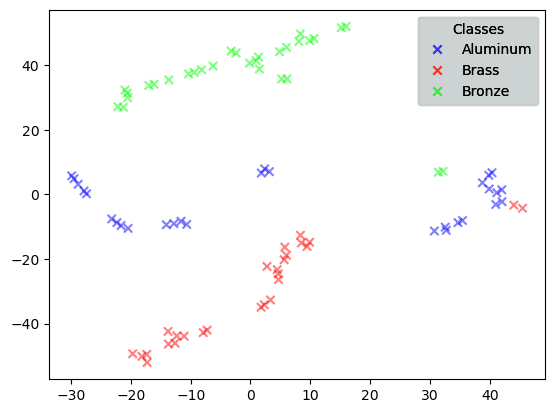

In [18]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], marker='x', c=ids, cmap='brg', alpha=0.5)
legends = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( id2label[str(i)] )
ax.add_artist(legends)
# for i, txt in enumerate(texts):
#     ax.annotate(txt, (X_embedded[i,0], X_embedded[i,1]))
# Create a Rectangle patch
x_start = 5
y_start = 20
x_length = 17
y_length = 22
# rect1 = patches.Rectangle((5, 20), 17, 22, linewidth=1, edgecolor='k', facecolor='none')
# rect2 = patches.Rectangle((-42, -15), 11, 25, linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect1)
# ax.add_patch(rect2)
plt.savefig('tsne0.png', dpi=300)
plt.savefig('tsne0.pdf')
plt.savefig('tsne0.svg')